# Sprint 1: Homography and Perspective Rectification

**Project:** Road Defect Detection Pipeline (PROSIT 1)  
**Team:** Naa Lamle Boye, Thomas Kojo Quarshie, Chelsea Owusu, Elijah Boateng  
**Date:** February 2026

## Purpose

This notebook transforms the perspective (dashboard camera) view of the road into a
**top-down (bird's-eye) view** where measurements can be made. The pothole's known
real-world dimensions (measured with tape) establish the scale: **10 pixels = 1 cm**.

**Deliverable:** Rectified top-down road image with verified metric scale.

## Step 1: Import Libraries and Load Image

Image loaded: 1287x2298 pixels


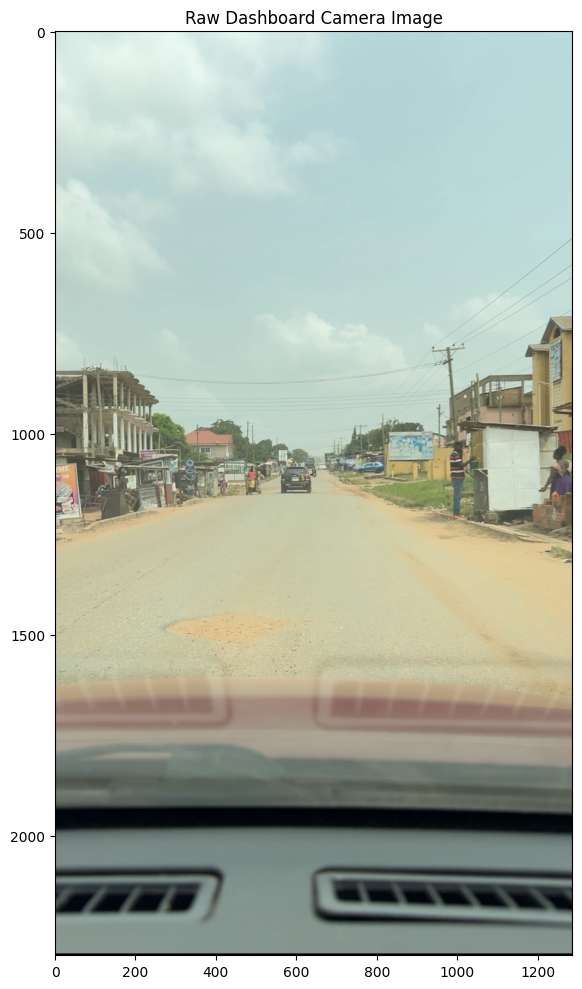

In [1]:
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pyplot as plt

raw_frame = cv2.imread('pothole_1.PNG')
if raw_frame is None:
    raise FileNotFoundError("Could not load pothole_1.PNG")

print(f"Image loaded: {raw_frame.shape[1]}x{raw_frame.shape[0]} pixels")

fig, ax = plt.subplots(figsize=(6, 10))
ax.imshow(cv2.cvtColor(raw_frame, cv2.COLOR_BGR2RGB))
ax.set_title("Raw Dashboard Camera Image")
plt.tight_layout()
plt.show()

## Step 2: Define Source Points (Pothole Corners)

The 4 corners of the pothole were identified by detecting the sandy/orange patch on
the road using color segmentation and computing its minimum-area bounding rectangle.

The pothole was measured on-site: **Width: 109.0 cm, Length: 112.0 cm**

**To use interactive selection:** In Jupyter, uncomment the interactive code block below,
run it, click the 4 corners (TL, TR, BR, BL), then update `src_pts`.

In [2]:
# ---- Hardcoded points (from automated detection of the sandy pothole patch) ----
# Order: Top-Left, Top-Right, Bottom-Right, Bottom-Left
src_pts = np.float32([
    [276, 1471],   # Top-Left
    [593, 1420],   # Top-Right
    [610, 1526],   # Bottom-Right
    [294, 1577]    # Bottom-Left
])

# ---- INTERACTIVE SELECTION (uncomment in Jupyter with ipympl) ----
# %matplotlib widget
# fig, ax = plt.subplots(figsize=(9, 14))
# ax.imshow(cv2.cvtColor(raw_frame, cv2.COLOR_BGR2RGB))
# ax.set_title("Click 4 Pothole Corners: TL -> TR -> BR -> BL")
# clicked_points = []
# def onclick(event):
#     if event.xdata is not None:
#         clicked_points.append([event.xdata, event.ydata])
#         ax.plot(event.xdata, event.ydata, 'ro', markersize=8)
#         fig.canvas.draw()
#         print(f"Point {len(clicked_points)}: ({int(event.xdata)}, {int(event.ydata)})")
#         if len(clicked_points) == 4:
#             fig.canvas.mpl_disconnect(cid)
#             print("Done! Now set: src_pts = np.float32(clicked_points)")
# cid = fig.canvas.mpl_connect('button_press_event', onclick)
# plt.show()

# Known pothole dimensions
POTHOLE_WIDTH_CM = 109.0
POTHOLE_LENGTH_CM = 112.0
SCALE = 10.0  # 10 pixels = 1 cm

print("Source points (image coordinates):")
for i, pt in enumerate(src_pts):
    print(f"  P{i+1}: ({pt[0]:.0f}, {pt[1]:.0f})")
print(f"\nPothole: {POTHOLE_WIDTH_CM} x {POTHOLE_LENGTH_CM} cm, Scale: {SCALE} px/cm")

Source points (image coordinates):
  P1: (276, 1471)
  P2: (593, 1420)
  P3: (610, 1526)
  P4: (294, 1577)

Pothole: 109.0 x 112.0 cm, Scale: 10.0 px/cm


## Step 3: Compute Homography Matrix

The homography H maps 4 source points (perspective view) to 4 destination points
(top-down rectangle), enabling the full image transformation.

In [3]:
dst_w = int(POTHOLE_WIDTH_CM * SCALE)   # 1090 px
dst_h = int(POTHOLE_LENGTH_CM * SCALE)  # 1120 px
PADDING = 500  # 50 cm padding

dst_pts = np.float32([
    [PADDING, PADDING],
    [PADDING + dst_w, PADDING],
    [PADDING + dst_w, PADDING + dst_h],
    [PADDING, PADDING + dst_h]
])

H, status = cv2.findHomography(src_pts, dst_pts)
print("Homography Matrix H:")
print(H)
print(f"\nCanvas: {2*PADDING+dst_w} x {2*PADDING+dst_h} px "
      f"= {(2*PADDING+dst_w)/SCALE:.0f} x {(2*PADDING+dst_h)/SCALE:.0f} cm")

Homography Matrix H:
[[ 3.20020336e+00 -5.57339656e-01  4.16016258e+02]
 [ 1.57736575e+00  9.81834178e+00 -1.43987080e+04]
 [-8.71976584e-06 -2.63370779e-05  1.00000000e+00]]

Canvas: 2090 x 2120 px = 209 x 212 cm


## Step 4: Apply Perspective Transformation

In [4]:
canvas_w = 2 * PADDING + dst_w
canvas_h = 2 * PADDING + dst_h
top_down_view = cv2.warpPerspective(raw_frame, H, (canvas_w, canvas_h))
print(f"Top-down view: {canvas_w}x{canvas_h} px")

Top-down view: 2090x2120 px


## Step 5: Scale Verification and Save

In [5]:
# 10cm scale bar
cv2.line(top_down_view, (50, 50), (150, 50), (0, 255, 0), 3)
cv2.putText(top_down_view, "10 cm (100 px)", (160, 58),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

# Pothole boundary
cv2.rectangle(top_down_view, (PADDING, PADDING),
              (PADDING+dst_w, PADDING+dst_h), (0, 255, 255), 2)
cv2.putText(top_down_view, f"Pothole: {POTHOLE_WIDTH_CM:.0f}x{POTHOLE_LENGTH_CM:.0f} cm",
            (PADDING, PADDING-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

cv2.imwrite('homography_topdown_output.png', top_down_view)
cv2.imwrite('topdown_full.png', top_down_view)

pothole_crop = top_down_view[PADDING:PADDING+dst_h, PADDING:PADDING+dst_w]
cv2.imwrite('topdown_pothole_region.png', pothole_crop)

print("Saved: homography_topdown_output.png")
print("Saved: topdown_full.png (for Sprint 2/3)")
print(f"Saved: topdown_pothole_region.png ({pothole_crop.shape[1]}x{pothole_crop.shape[0]})")

Saved: homography_topdown_output.png
Saved: topdown_full.png (for Sprint 2/3)
Saved: topdown_pothole_region.png (1090x1120)


## Step 6: Visualization and Comparison

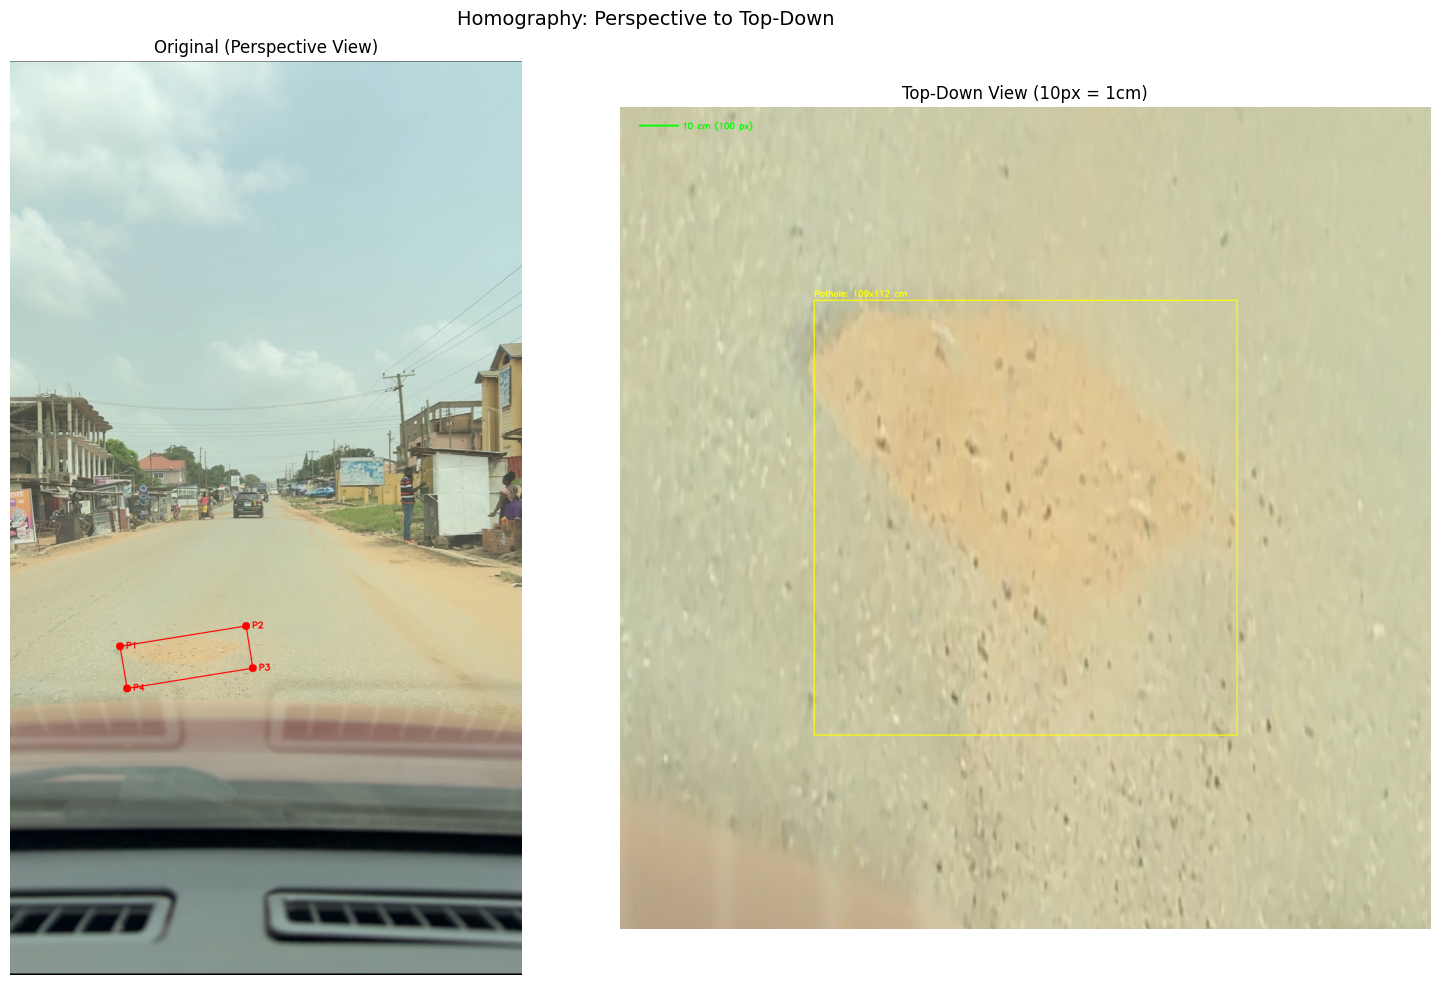

Saved: homography_comparison.png


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

img_vis = raw_frame.copy()
for i, pt in enumerate(src_pts.astype(int)):
    cv2.circle(img_vis, tuple(pt), 10, (0, 0, 255), -1)
    cv2.putText(img_vis, f"P{i+1}", (pt[0]+15, pt[1]+5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
cv2.polylines(img_vis, [src_pts.astype(int).reshape(-1,1,2)], True, (0,0,255), 2)

axes[0].imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original (Perspective View)")
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(top_down_view, cv2.COLOR_BGR2RGB))
axes[1].set_title("Top-Down View (10px = 1cm)")
axes[1].axis('off')

plt.suptitle("Homography: Perspective to Top-Down", fontsize=14)
plt.tight_layout()
plt.savefig('homography_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: homography_comparison.png")

## Step 7: Extended Road View

Show a wider top-down view with more road context around the pothole.
This uses larger padding to capture the road ahead and behind the pothole.

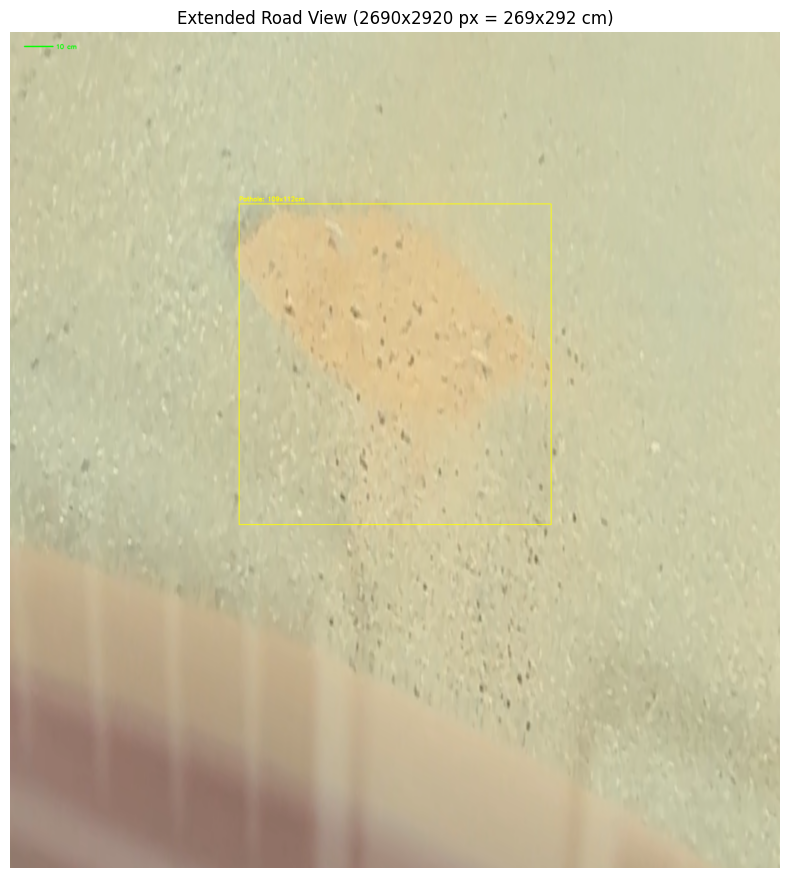

Extended view: 2690x2920 px = 269x292 cm
Saved: homography_fullview.png

Homography complete. Proceed to Sprint 2.


In [7]:
# Extended road view with more context
PADDING_X = 800   # 80 cm left/right
PADDING_TOP = 600  # 60 cm above pothole
PADDING_BOT = 1200 # 120 cm below pothole (toward camera)

dst_wide = np.float32([
    [PADDING_X, PADDING_TOP],
    [PADDING_X + dst_w, PADDING_TOP],
    [PADDING_X + dst_w, PADDING_TOP + dst_h],
    [PADDING_X, PADDING_TOP + dst_h]
])

H_wide, _ = cv2.findHomography(src_pts, dst_wide)
cw = 2 * PADDING_X + dst_w
ch = PADDING_TOP + dst_h + PADDING_BOT

full_road = cv2.warpPerspective(raw_frame, H_wide, (cw, ch))

# Scale bar and pothole boundary
cv2.line(full_road, (50, 50), (150, 50), (0, 255, 0), 3)
cv2.putText(full_road, "10 cm", (160, 58), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
cv2.rectangle(full_road, (PADDING_X, PADDING_TOP),
              (PADDING_X+dst_w, PADDING_TOP+dst_h), (0, 255, 255), 2)
cv2.putText(full_road, f"Pothole: {POTHOLE_WIDTH_CM:.0f}x{POTHOLE_LENGTH_CM:.0f}cm",
            (PADDING_X, PADDING_TOP-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

cv2.imwrite('homography_fullview.png', full_road)

fig, ax = plt.subplots(figsize=(8, 10))
ax.imshow(cv2.cvtColor(full_road, cv2.COLOR_BGR2RGB))
ax.set_title(f"Extended Road View ({cw}x{ch} px = {cw/SCALE:.0f}x{ch/SCALE:.0f} cm)")
ax.axis('off')
plt.tight_layout()
plt.savefig('homography_fullview_plot.png', dpi=100, bbox_inches='tight')
plt.show()
print(f"Extended view: {cw}x{ch} px = {cw/SCALE:.0f}x{ch/SCALE:.0f} cm")
print("Saved: homography_fullview.png")
print("\nHomography complete. Proceed to Sprint 2.")